In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix, mean_squared_error

from collections import defaultdict

sns.set()

## Klasyfikacja

In [377]:
train_df = pd.read_csv(
    '../data/airline_passenger_satisfaction/train.csv', index_col=0)
test_df = pd.read_csv(
    '../data/airline_passenger_satisfaction/test.csv', index_col=0)


In [378]:
train_df, val_df = train_test_split(train_df, random_state=710, test_size=0.2)

In [379]:
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
56437,115299,Female,Loyal Customer,39,Business travel,Business,325,1,1,3,...,4,4,4,4,4,4,3,1,1.0,satisfied
7268,91149,Male,Loyal Customer,28,Personal Travel,Eco,581,3,3,3,...,5,4,5,3,1,3,5,0,0.0,neutral or dissatisfied
4355,84666,Female,disloyal Customer,29,Business travel,Business,1090,0,0,0,...,5,5,3,5,5,4,5,0,1.0,satisfied
36283,83680,Male,Loyal Customer,42,Business travel,Business,577,4,3,4,...,3,3,3,3,4,3,3,18,35.0,satisfied
54910,76176,Female,Loyal Customer,23,Business travel,Eco Plus,289,5,1,1,...,5,5,3,1,5,4,5,17,5.0,satisfied


In [380]:
train_df.isna().sum()


id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             249
satisfaction                           0
dtype: int64

Zakładam, że jeśli `Arrival Delay in Minutes` jest nullem, to znaczy, że nie było opóźnienia

In [381]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 83123 entries, 56437 to 91878
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 83123 non-null  int64  
 1   Gender                             83123 non-null  object 
 2   Customer Type                      83123 non-null  object 
 3   Age                                83123 non-null  int64  
 4   Type of Travel                     83123 non-null  object 
 5   Class                              83123 non-null  object 
 6   Flight Distance                    83123 non-null  int64  
 7   Inflight wifi service              83123 non-null  int64  
 8   Departure/Arrival time convenient  83123 non-null  int64  
 9   Ease of Online booking             83123 non-null  int64  
 10  Gate location                      83123 non-null  int64  
 11  Food and drink                     83123 non-null 

Występują zmienne kategoryczne, które należy zakodować

In [382]:
X_train = train_df.drop(columns=['satisfaction'])
y_train = train_df['satisfaction']

X_val = val_df.drop(columns=['satisfaction'])
y_val = val_df['satisfaction']

X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']

In [383]:
categorical_columns = X_train.select_dtypes('object').columns.to_list()
numeric_columns = X_train.select_dtypes('number').columns.to_list()


In [384]:
class ColumnDropperTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)

    def fit(self, X, y=None):
        return self


In [385]:
numeric_transformer = Pipeline(
                        steps=[
                            # id nie wnosi informacji do modelu, więc dropujemy kolumnę
                            ("id_dropper", ColumnDropperTransformer(columns=['id'])),
                            ("scaler", StandardScaler())
                        ]
                      )

arrival_delay_imp = Pipeline(
                        steps=[
                            # jeśli arraval delay jest nullem, to prawdopodobnie go nie było
                            ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                            ("scaler", StandardScaler())
                        ]
                      )
categorical_transformer = OneHotEncoder(drop='first')

numeric_columns_transf = numeric_columns
numeric_columns_transf.remove('Arrival Delay in Minutes')

preprocessor = ColumnTransformer(
    transformers=[
        ('arrival_delay_imp', arrival_delay_imp, ['Arrival Delay in Minutes']),
        ("num", numeric_transformer, numeric_columns_transf),
        ("cat", categorical_transformer, categorical_columns),
    ]
)

In [386]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_val = le.transform(y_val)
y_test = le.transform(y_test)

le.classes_

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [387]:
def statistics_classification(y, y_pred, y_pred_proba):
    
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.title('Confusion matrix')
    plt.show()

    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')

### Random Forest

In [388]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=710))
    ]
)

In [389]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('arrival_delay_imp',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Arrival Delay in Minutes']),
                                                 ('num',
                                                  Pipeline(steps=[('id_dropper',
                                                                   <__main__.ColumnDropperTransformer object at 0x0000018D2421D910>),
                                                                  ('scaler',
                        

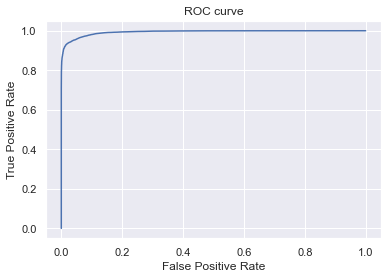

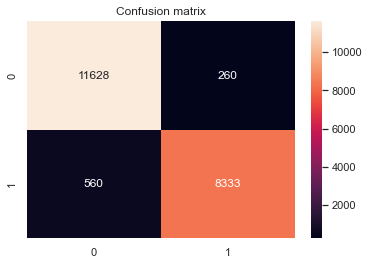

accuracy=0.9605408786872625
recall=0.937029124030136
f1=0.95310534141599


In [390]:
y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

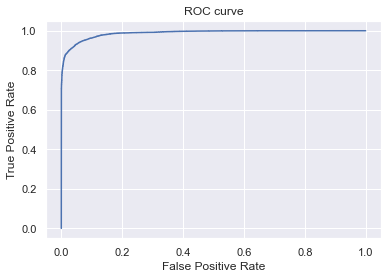

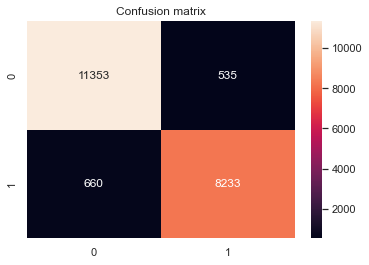

accuracy=0.9424955488186324
recall=0.9257843247498032
f1=0.9323367872713889


In [391]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=710))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

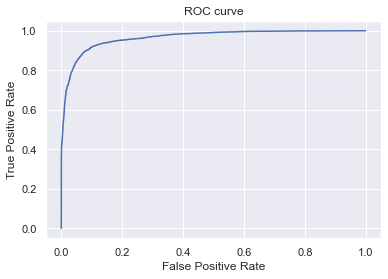

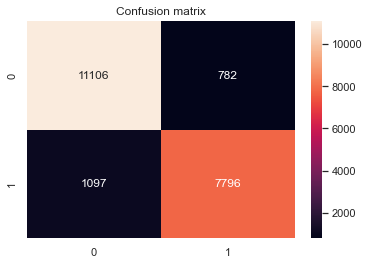

accuracy=0.9095808671382513
recall=0.8766445518947487
f1=0.8924503462881346


In [392]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1, random_state=710))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

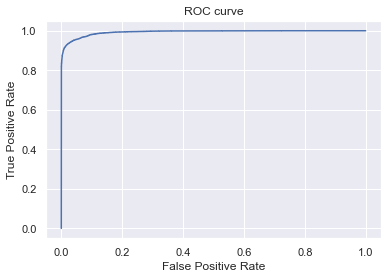

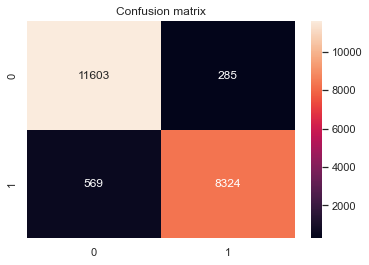

accuracy=0.9589047687791733
recall=0.9360170920949061
f1=0.9512055765055423


In [393]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(max_depth=20, n_estimators=100, n_jobs=-1, random_state=710))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

Ograniczenie głębokości drzewa (defaultowo ono nie istnieje), spowodowało spadek osiągów na zbiorze walidacyjnym. Ogólnie takie ograniczenie powinno mieć regularyzować model.

Sprecyzowanie liczby estymatorów w tym przypadku zdaje się nie mieć wpływu na skuteczność modelu.

### XGBClassifier

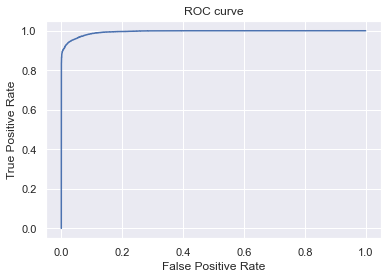

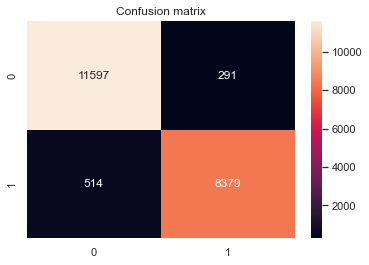

accuracy=0.9612626918820076
recall=0.9422017316990892
f1=0.9541650059784775


In [394]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(objective="binary:logistic", seed=710, use_label_encoder=False))
    ]
)

xgb_clf.fit(X_train, y_train, classifier__eval_metric="error")

y_pred = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

[0]	validation_0-error:0.08898
[1]	validation_0-error:0.07738
[2]	validation_0-error:0.07069
[3]	validation_0-error:0.06559
[4]	validation_0-error:0.06400
[5]	validation_0-error:0.06410
[6]	validation_0-error:0.06044
[7]	validation_0-error:0.05818
[8]	validation_0-error:0.05674
[9]	validation_0-error:0.05587
[10]	validation_0-error:0.05337
[11]	validation_0-error:0.05346
[12]	validation_0-error:0.05356
[13]	validation_0-error:0.05289
[14]	validation_0-error:0.05144
[15]	validation_0-error:0.05168
[16]	validation_0-error:0.05077
[17]	validation_0-error:0.04995
[18]	validation_0-error:0.04913
[19]	validation_0-error:0.04846
[20]	validation_0-error:0.04740
[21]	validation_0-error:0.04673
[22]	validation_0-error:0.04596
[23]	validation_0-error:0.04557
[24]	validation_0-error:0.04499
[25]	validation_0-error:0.04437
[26]	validation_0-error:0.04442
[27]	validation_0-error:0.04437
[28]	validation_0-error:0.04393
[29]	validation_0-error:0.04393
[30]	validation_0-error:0.04336
[31]	validation_0-

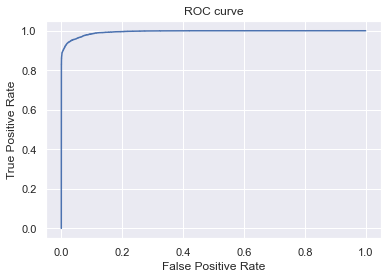

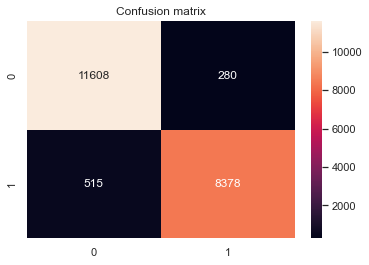

accuracy=0.9617439006785043
recall=0.9420892837062859
f1=0.9547034357016695


In [395]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(objective="binary:logistic", seed=710, use_label_encoder=False))
    ]
)

xgb_clf.fit(X_train, y_train,
            classifier__eval_metric="error",
            classifier__early_stopping_rounds=5,
            classifier__eval_set=[(xgb_clf['preprocessor'].transform(X_val), y_val)],
            classifier__verbose=True)

y_pred = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

Early stopping pomógł w niewielkim stopniu podnieść osiągi modelu

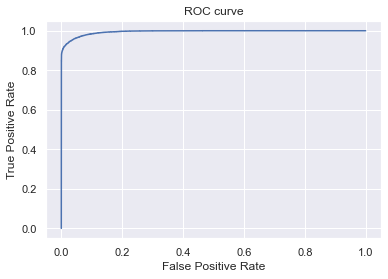

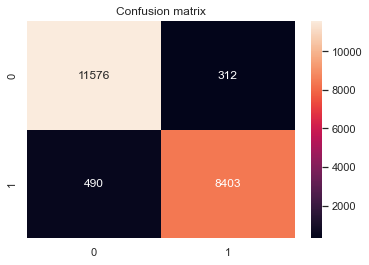

accuracy=0.9614070545209566
recall=0.944900483526369
f1=0.9544525215810995


In [396]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(objective="binary:logistic", max_depth=10, seed=710, use_label_encoder=False))
    ]
)

xgb_clf.fit(X_train, y_train,
            classifier__eval_metric="error")

y_pred = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

Ograniczenie maksymalnej głębokości pozwoliło na drobne poprawienie recallu

XGBoost radzi sobie z tym problemem nieznacznie lepiej

## Regresja

!! `train_df`, `X_train`, `y_train`, będą zawierać teraz inne informacje !!

In [397]:
df = pd.read_csv('../data/car_prices_poland/Car_Prices_Poland.csv', index_col=0)
cities = pd.read_csv('../data/car_prices_poland/miasta.csv')

cities = cities[['Miasto', 'Kategoria']]

In [398]:
df.shape

(117927, 10)

In [399]:
train_df, val_df = train_test_split(df, random_state=710, test_size=0.3)
val_df, test_df = train_test_split(val_df, random_state=710, test_size=0.3)

In [400]:
train_df.head()

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
23654,audi,s5,NaN,2019,19000,2995,Gasoline,Opole,Opolskie,189000
72440,toyota,corolla,gen-e21-2019,2019,25329,1197,Gasoline,Grudziądz,Kujawsko-pomorskie,85500
10218,opel,mokka,NaN,2021,10,1199,Gasoline,Warszawa,Mazowieckie,107800
37486,volkswagen,golf,gen-vi-2008-2013,2009,163000,1595,LPG,Rumia,Pomorskie,19300
51018,ford,ka,gen-ii-2008-ka,2010,117781,1242,Gasoline,Końskie,Świętokrzyskie,13500


In [401]:
train_df.isna().sum()

mark                   0
model                  0
generation_name    21072
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

In [402]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82548 entries, 23654 to 91878
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mark             82548 non-null  object
 1   model            82548 non-null  object
 2   generation_name  61476 non-null  object
 3   year             82548 non-null  int64 
 4   mileage          82548 non-null  int64 
 5   vol_engine       82548 non-null  int64 
 6   fuel             82548 non-null  object
 7   city             82548 non-null  object
 8   province         82548 non-null  object
 9   price            82548 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 6.9+ MB


In [403]:
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

X_val = val_df.drop(columns=['price'])
y_val = val_df['price']

X_test = test_df.drop(columns=['price'])
y_test = test_df['price']

In [404]:
class CityEncoderTransformer():
    def __init__(self, cities):
        # self.cities = cities
        self.city_map_dict = defaultdict(lambda: 'Other', dict(zip(cities['Miasto'], cities['Kategoria'])))

    def transform(self, X, y=None):
        X.loc[:, 'city'] = X['city'].map(self.city_map_dict)
        # tmp = X.merge(self.cities, left_on='city', right_on='Miasto', how='left')
        # tmp = tmp.drop(columns=['city', 'Miasto'])
        # tmp['Kategoria'].fillna('other')
        # return tmp
        return X

    def fit(self, X, y=None):
        return self


In [405]:
categorical_columns = X_train.select_dtypes('object').columns.to_list()
numeric_columns = X_train.select_dtypes('number').columns.to_list()

numeric_transformer = StandardScaler()

city_encoder = Pipeline(
                        steps=[
                            # kategoryzacja miast
                            ('city_enc', CityEncoderTransformer(cities=cities)),
                            ("onehot", OneHotEncoder(drop='first'))
                        ]
                      )

categorical_transformer = Pipeline(
                        steps=[
                            # z generation name ciężko wyciągnąć informacje i zawiera dużo braków, więc dropujemy kolumnę
                            ("col_dropper", ColumnDropperTransformer(columns=['generation_name'])),
                            ("onehot", OneHotEncoder(drop='first'))
                        ]
                      )

categorical_columns_transf = categorical_columns
categorical_columns_transf.remove('city')

preprocessor = ColumnTransformer(
    transformers=[
        ('city_encoder', city_encoder, ['city']),
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns_transf),
    ]
)

### Random Forest Regressor

In [406]:
rf_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestRegressor(max_depth=10, random_state=710, n_jobs=-1))
    ]
)

In [407]:
rf_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('city_encoder',
                                                  Pipeline(steps=[('city_enc',
                                                                   <__main__.CityEncoderTransformer object at 0x0000018D2361B310>),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['city']),
                                                 ('num', StandardScaler(),
                                                  ['year', 'mileage',
                                                   'vol_engine']),
                                                 ('cat',
                                                  Pipeline(steps=[('col_dropper',
                                                                   <__main__.ColumnDropperTransformer 

In [408]:
y_pred = rf_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 24966.320750863124


In [409]:
rf_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestRegressor(max_depth=5, random_state=710, n_jobs=-1))
    ]
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 33692.01310200933


In [410]:
rf_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestRegressor(max_depth=15, random_state=710, n_jobs=-1))
    ]
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 21525.88793980143


Jak widać, w tym wypadku większa głębokość pozwala minimalizować błąd średniokwadratowy na zbiorze walidacyjnym (choć w pewnym momencie model zacznie się przetrenowywać)

### XGBRegressor

In [411]:
xgb_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBRegressor(objective ='reg:squarederror', max_depth=5, n_estimators = 10, seed = 710))
    ]
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 26783.024412800663


In [412]:
xgb_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBRegressor(objective ='reg:squarederror', max_depth=10, n_estimators = 10, seed = 710))
    ]
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 21509.137549804553


In [413]:
xgb_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBRegressor(objective ='reg:squarederror', max_depth=15, n_estimators = 10, seed = 710))
    ]
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 20657.237141972786


In [414]:
xgb_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBRegressor(objective ='reg:squarederror', max_depth=35, n_estimators = 10, seed = 710))
    ]
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RMSE: 20480.207170121586


Dalsze podnoszenie głębokości xgboosta zmniejsza błąd, jednak po pewnej wartości zysk jest niewielki

Również w przypadku regresji XGBoost osiąga nieznacznie lepsze wyniki. Tym razem jednak jego dodatkową przewagą jest znacznie szybszy przebieg treningu.